# Measuring synchronization of LFE activity in Parkfield

In [43]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [44]:
mag_min = 2.2

# Load data

In [45]:
# LFE and LFE families
lfe_fam = pd.read_csv('data/parkfield/processed/park_lfe_fam_0606_0122_eqdist_mc{:.1f}.csv'.format(mag_min))
lfe = pd.read_csv('data/parkfield/processed/park_lfe_0606_0122.csv'.format(mag_min), parse_dates=['date'])

# Associate to each LFE the number of earthquakes felt at its location
for id in lfe_fam.id.values:
    lfe.loc[lfe.ID == id, 'n_eq_10km'] = lfe_fam.loc[lfe_fam.id == id, 'n_eq_10km'].values[0]
    lfe.loc[lfe.ID == id, 'n_eq_20km'] = lfe_fam.loc[lfe_fam.id == id, 'n_eq_20km'].values[0]
    lfe.loc[lfe.ID == id, 'n_eq_30km'] = lfe_fam.loc[lfe_fam.id == id, 'n_eq_30km'].values[0]
    lfe.loc[lfe.ID == id, 'n_eq_50km'] = lfe_fam.loc[lfe_fam.id == id, 'n_eq_50km'].values[0]
    lfe.loc[lfe.ID == id, 'n_eq_100km'] = lfe_fam.loc[lfe_fam.id == id, 'n_eq_100km'].values[0]


In [46]:
# Load earthquakes
eq = pd.read_csv('data/parkfield/processed/park_eqmc{:.1f}_0606_0122_eqdist.csv'.format(mag_min), parse_dates=['date'])

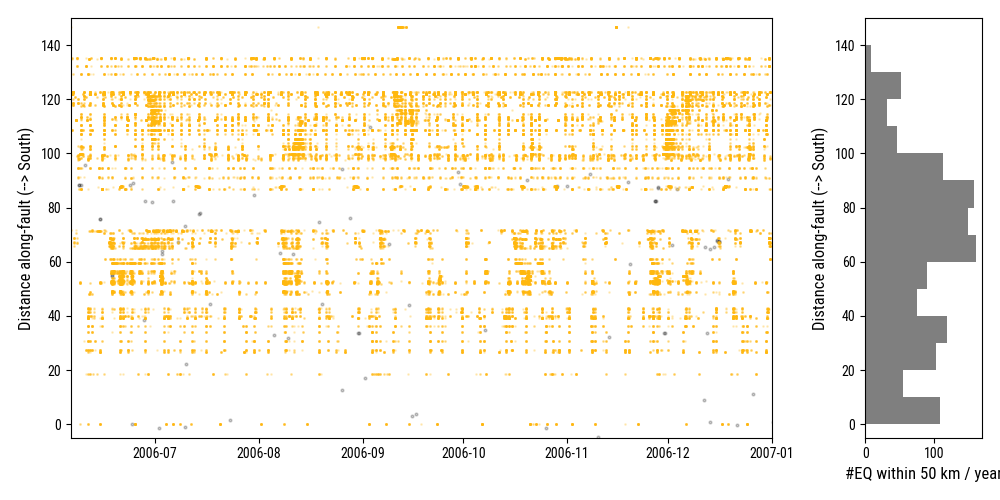

In [47]:
# Overview
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1])

# Activity
ax = fig.add_subplot(gs[:, 0])
ax.set_ylabel('Distance along-fault (--> South)')

ax.plot(lfe.date, lfe.xf, 'o', ms=1, c=to_rgba('C2', .2))
ax.plot(eq.date[eq.in50km], eq.xf[eq.in50km], 'o', ms=2, c=to_rgba('k', .2), zorder=0)

ax.set_ylim(-5, 150)
ax.set_xlim(np.datetime64('2006-06-06'), np.datetime64('2007-01-01'))  

# Histogram
ax = fig.add_subplot(gs[:, 1], sharey=ax)
ax.set_xlabel('#EQ within 50 km / year')
ax.set_ylabel('Distance along-fault (--> South)')

ax.hist(eq.xf[eq.in50km], bins=np.arange(0, 150, 10), color='k', alpha=.5, orientation='horizontal')

plt.tight_layout()
plt.show()

# Compute correlation distance

In [48]:
# Trim in time to only published catalog?
interval = [np.datetime64('2006-06-06'), np.datetime64('2022-12-31')]
lfe = lfe[(lfe.date >= interval[0]) & (lfe.date <= interval[1])]
eq = eq[(eq.date >= interval[0]) & (eq.date <= interval[1])]

In [49]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 0
xmax_bin = 150
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [50]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, lfe.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    lfe_in_bin = lfe.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(lfe[lfe_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    print('{}/{}'.format(ii, len(x_bin_edges)-1), end='\r')
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

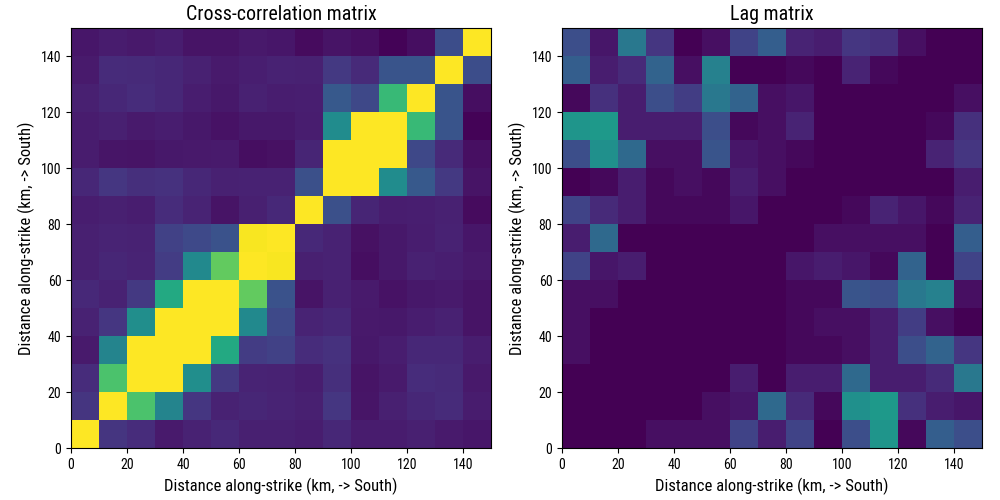

In [51]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

# from matplotlib.colors import LinearSegmentedColormap
# nlow = int(256 * 0.1 // 1)
# nhigh = int(256 - nlow)
# cm_low = plt.cm.Greys_r(np.linspace(0, 1, nlow))
# cm_high = plt.cm.YlOrBr_r(np.linspace(0, 1, nhigh))
# colors = np.vstack((cm_low, cm_high))
# mymap = LinearSegmentedColormap.from_list('my_colormap', colors)

cax = ax.imshow(cc_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], origin='lower', cmap='viridis', vmin=0, vmax=.4)
ax.set_xlabel('Distance along-strike (km, -> South)')
ax.set_ylabel('Distance along-strike (km, -> South)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> South)')
ax.set_ylabel('Distance along-strike (km, -> South)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

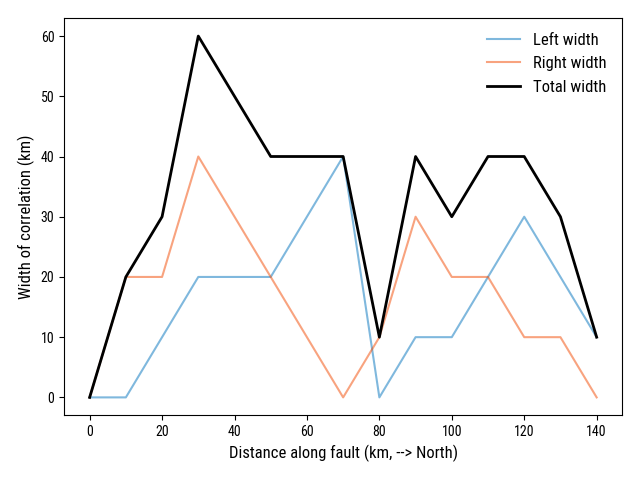

In [52]:
# Look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', lw=2)
ax.legend()
plt.tight_layout()
plt.show()

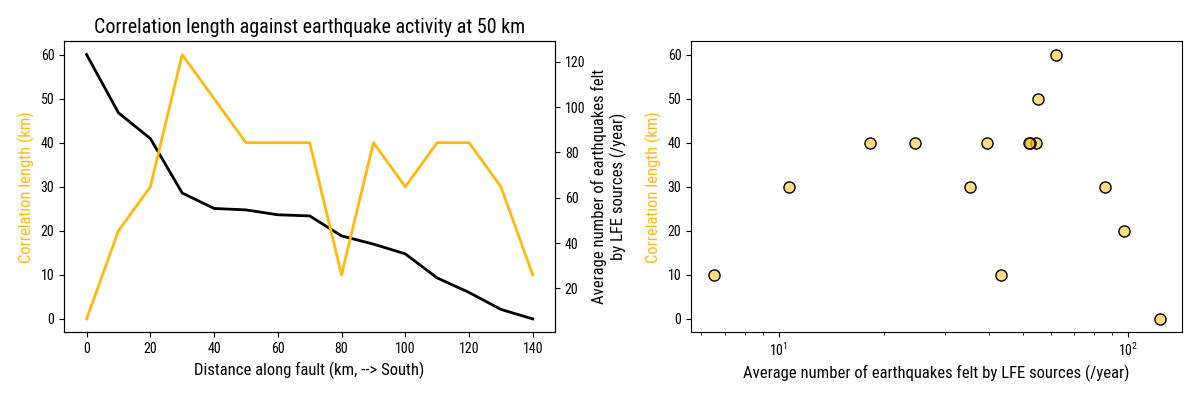

In [53]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        lfe_in_bin = lfe[lfe.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(lfe_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 50
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> South)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby LFE sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by LFE sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [54]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta, 'min_mag': mag_min}

path = 'results/park_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print(f'Saving at {path}')
    pickle.dump(results, f)

Saving at results/park_synch_mc2.2_dx10_cc0.07.pkl


# Figures for paper

In [55]:
interval = [np.datetime64('2006-06-06'), np.datetime64('2007-01-01')]
lfe_in_range = lfe[(lfe.date >= interval[0]) & (lfe.date <= interval[1])]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_20402/2150980396.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('C4', .5), label='Low-frequency earthquakes')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_20402/2150980396.py:104: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')


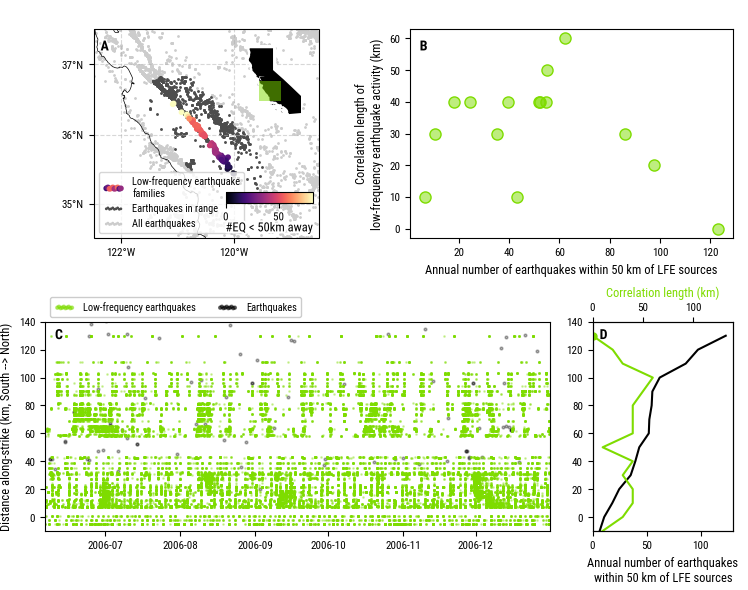

In [62]:
# Plot
import matplotlib.patheffects as fx

with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.06, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=lfe_fam.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(lfe_fam.lon, lfe_fam.lat, c=lfe_fam.n_eq_50km, s=10, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(lfe_fam.n_eq_50km, 95), zorder=2, label='Low-frequency earthquake\nfamilies', rasterized=True)
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize='small', framealpha=.8, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = 0.56; y_min_ax = 0.17
    w_ax = 0.27; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(chosen_dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.03, 0.95, 'A', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Inset
    # get New Zealand country shape
    import shapely.geometry as sgeom
    import cartopy.io.shapereader as shpreader

    shpfilename = shpreader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_1_states_provinces_lakes')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    california = None
    for country in countries:
        if country.attributes['name'] == 'California':
            california = country.geometry

    ax = plt.axes([.3, .8, .13, .13], projection=ccrs.Mercator())
    ax.axis('off')
    ax.set_extent([-125, -115, 32, 43], crs=ccrs.PlateCarree())
    ax.add_geometries([california], ccrs.PlateCarree(), facecolor='k', edgecolor='w', lw=4, zorder=0)    
    ax.add_geometries([california], ccrs.PlateCarree(), facecolor='k', edgecolor='none', lw=1, zorder=2)

    # show patch of main map
    rect = plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(), edgecolor='none', facecolor=to_rgba('C4', .5), zorder=3)
    ax.add_patch(rect)

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel('Annual number of earthquakes within 50 km of LFE sources')
    ax.set_ylabel('Correlation length of\nlow-frequency earthquake activity (km)')

    ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='C4', mfc=to_rgba('C4', .5))

    # ax.set_xlim(9, 200)
    # ax.set_xscale('log')
    # ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, South --> North)')

    ax.plot(lfe_in_range.date, 130 - lfe_in_range.xf, 'o', ms=1, color=to_rgba('C4', .3), rasterized=True)
    ax.plot(eq.date[eq.in50km], 130 - eq.xf[eq.in50km], 'o', ms=2., color=to_rgba('k', .3), zorder=0, rasterized=True)

    ax.set_xlim(lfe_in_range.date.min(), lfe_in_range.date.max())
    ax.set_ylim(-10, 140)

    ax.scatter([], [], s=5, c=to_rgba('C4', .5), label='Low-frequency earthquakes')
    ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of LFE sources')
    ax.set_xlim(0, 130)

    ax.plot(n_close_eq[chosen_dist], 130 - x_bin_edges[:-1], c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 140)
    ax_cc.plot(corr_length, 130 - x_bin_edges[:-1], c='C4')
    ax_cc.plot(corr_length[corr_length==0], 130 - x_bin_edges[:-1][corr_length==0], c='C4', marker='o', ms=5)
    ax_cc.set_xlabel('Correlation length (km)', color='C4')

    ax.text(0.05, 0.97, 'D', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    
    plt.savefig('figures/parkfield_supp.png', dpi=300)
    plt.savefig('figures/parkfield_supp.pdf', dpi=300)
    plt.show()